# Fine-Tuning do SAM - Análise Completa

## Segmentação de Buracos em Ruas

Este notebook apresenta uma análise completa do Segment Anything Model (SAM) para segmentação de buracos em ruas, incluindo:

1. **Avaliação de diferentes tipos de prompts** (BBOX, Point, Automatic)
2. **Comparação entre modelos SAM** (ViT-B, ViT-L, ViT-H)
3. **Fine-tuning sistemático**
4. **Grounded-SAM** (text prompts)
5. **Segmentação iterativa**
6. **Comparação quantitativa** com métricas IoU e Dice

---

## 1. Setup e Instalação de Dependências

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Copie sua pasta 'Data Segmentation' do Google Drive para o diretório atual do Colab
!cp -r "/content/drive/My Drive/Data Segmentation" "./Data Segmentation"

# Verifique se a pasta foi copiada com sucesso listando seu conteúdo
!ls -F "./Data Segmentation/train/images"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pic-100-_jpg.rf.17047bb032a49c96643c5f2108bb99dd.jpg
pic-100-_jpg.rf.8c9076ee84698f90f04765f4e794a819.jpg
pic-100-_jpg.rf.ebc3af260e989e6f9e1e9221b9dff6b0.jpg
pic-101-_jpg.rf.1e32a49f89a38974ded11bba8dd3e56b.jpg
pic-101-_jpg.rf.4abe48a3d2a5e556908bf4286446e5ce.jpg
pic-101-_jpg.rf.8380b58f6540ec91db66934b342f7f9e.jpg
pic-102-_jpg.rf.bb6db5bdb59d1a6af15b0a0b565a3cdb.jpg
pic-102-_jpg.rf.cd0b0b3a64e3a11005884c98c1f6c3aa.jpg
pic-102-_jpg.rf.df35bf045672f19a05f84a8c365dab3a.jpg
pic-103-_jpg.rf.26017e20e92320bcde575710389353b1.jpg
pic-103-_jpg.rf.4fa35472ae606aca56d49966dc91b5b6.jpg
pic-103-_jpg.rf.e204fd0f4f80094ec52c54c31ab06db0.jpg
pic-104-_jpg.rf.117ec7cfcc77d6e6f80130934b1d5aa1.jpg
pic-104-_jpg.rf.e4efc52e048da0b6918c135b1bd39962.jpg
pic-104-_jpg.rf.f986cb78d75fc164de95ac33c56d9474.jpg
pic-105-_jpg.rf.0b52d3fe11f0b249a5eb2f14a8f0a14f.jpg
pic-105-_jpg.rf.0ce0939

In [2]:
# Instalação das dependências
!pip install segment-anything torch torchvision opencv-python matplotlib numpy tqdm pandas
!pip install groundingdino-py supervision  # Para Grounded-SAM

In [3]:
# Imports principais
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from segment_anything.utils.transforms import ResizeLongestSide
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Configuração do device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Usando device: {device}")
print(f"🔥 CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📊 GPU: {torch.cuda.get_device_name(0)}")

🖥️  Usando device: cuda
🔥 CUDA disponível: True
📊 GPU: Tesla T4


## 2. Dataset e Utilitários

In [4]:
# Dataset personalizado
class StreetHoleDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_name = img_name.rsplit('.', 1)[0] + '_mask.png'
        mask_path = os.path.join(self.masks_dir, mask_name)

        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype(np.uint8)
        else:
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

        return {
            'image': image,
            'mask': mask,
            'filename': img_name
        }

# Criar datasets
train_dataset = StreetHoleDataset(
    images_dir='Data Segmentation/train/images',
    masks_dir='Data Segmentation/masks_train'
)

val_dataset = StreetHoleDataset(
    images_dir='Data Segmentation/valid/images',
    masks_dir='Data Segmentation/masks_valid'
)

print(f"📚 Dataset de treino: {len(train_dataset)} imagens")
print(f"📚 Dataset de validação: {len(val_dataset)} imagens")

📚 Dataset de treino: 720 imagens
📚 Dataset de validação: 60 imagens


In [5]:
# Funções de métricas
def calculate_iou(pred_mask, gt_mask):
    """Calcula Intersection over Union (IoU)"""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

def calculate_dice(pred_mask, gt_mask):
    """Calcula Dice Coefficient"""
    intersection = np.logical_and(pred_mask, gt_mask).sum()

    if pred_mask.sum() + gt_mask.sum() == 0:
        return 1.0

    return 2 * intersection / (pred_mask.sum() + gt_mask.sum())

def calculate_metrics(pred_mask, gt_mask):
    """Calcula todas as métricas"""
    return {
        'iou': calculate_iou(pred_mask, gt_mask),
        'dice': calculate_dice(pred_mask, gt_mask)
    }

def dice_loss(logits, target):
    """Dice Loss para treinamento"""
    p = torch.sigmoid(logits)
    inter = (p * target).sum()
    union = p.sum() + target.sum()
    return 1 - (2 * inter + 1e-6) / (union + 1e-6)

In [6]:
# Funções auxiliares para prompts
def get_bbox_from_mask(mask):
    """Extrai bounding box da máscara"""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not rows.any() or not cols.any():
        return None

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return np.array([cmin, rmin, cmax, rmax])

def get_center_point_from_mask(mask):
    """Extrai ponto central da máscara"""
    rows, cols = np.where(mask > 0)

    if len(rows) == 0:
        return None

    center_y = int(np.mean(rows))
    center_x = int(np.mean(cols))

    return np.array([[center_x, center_y]])

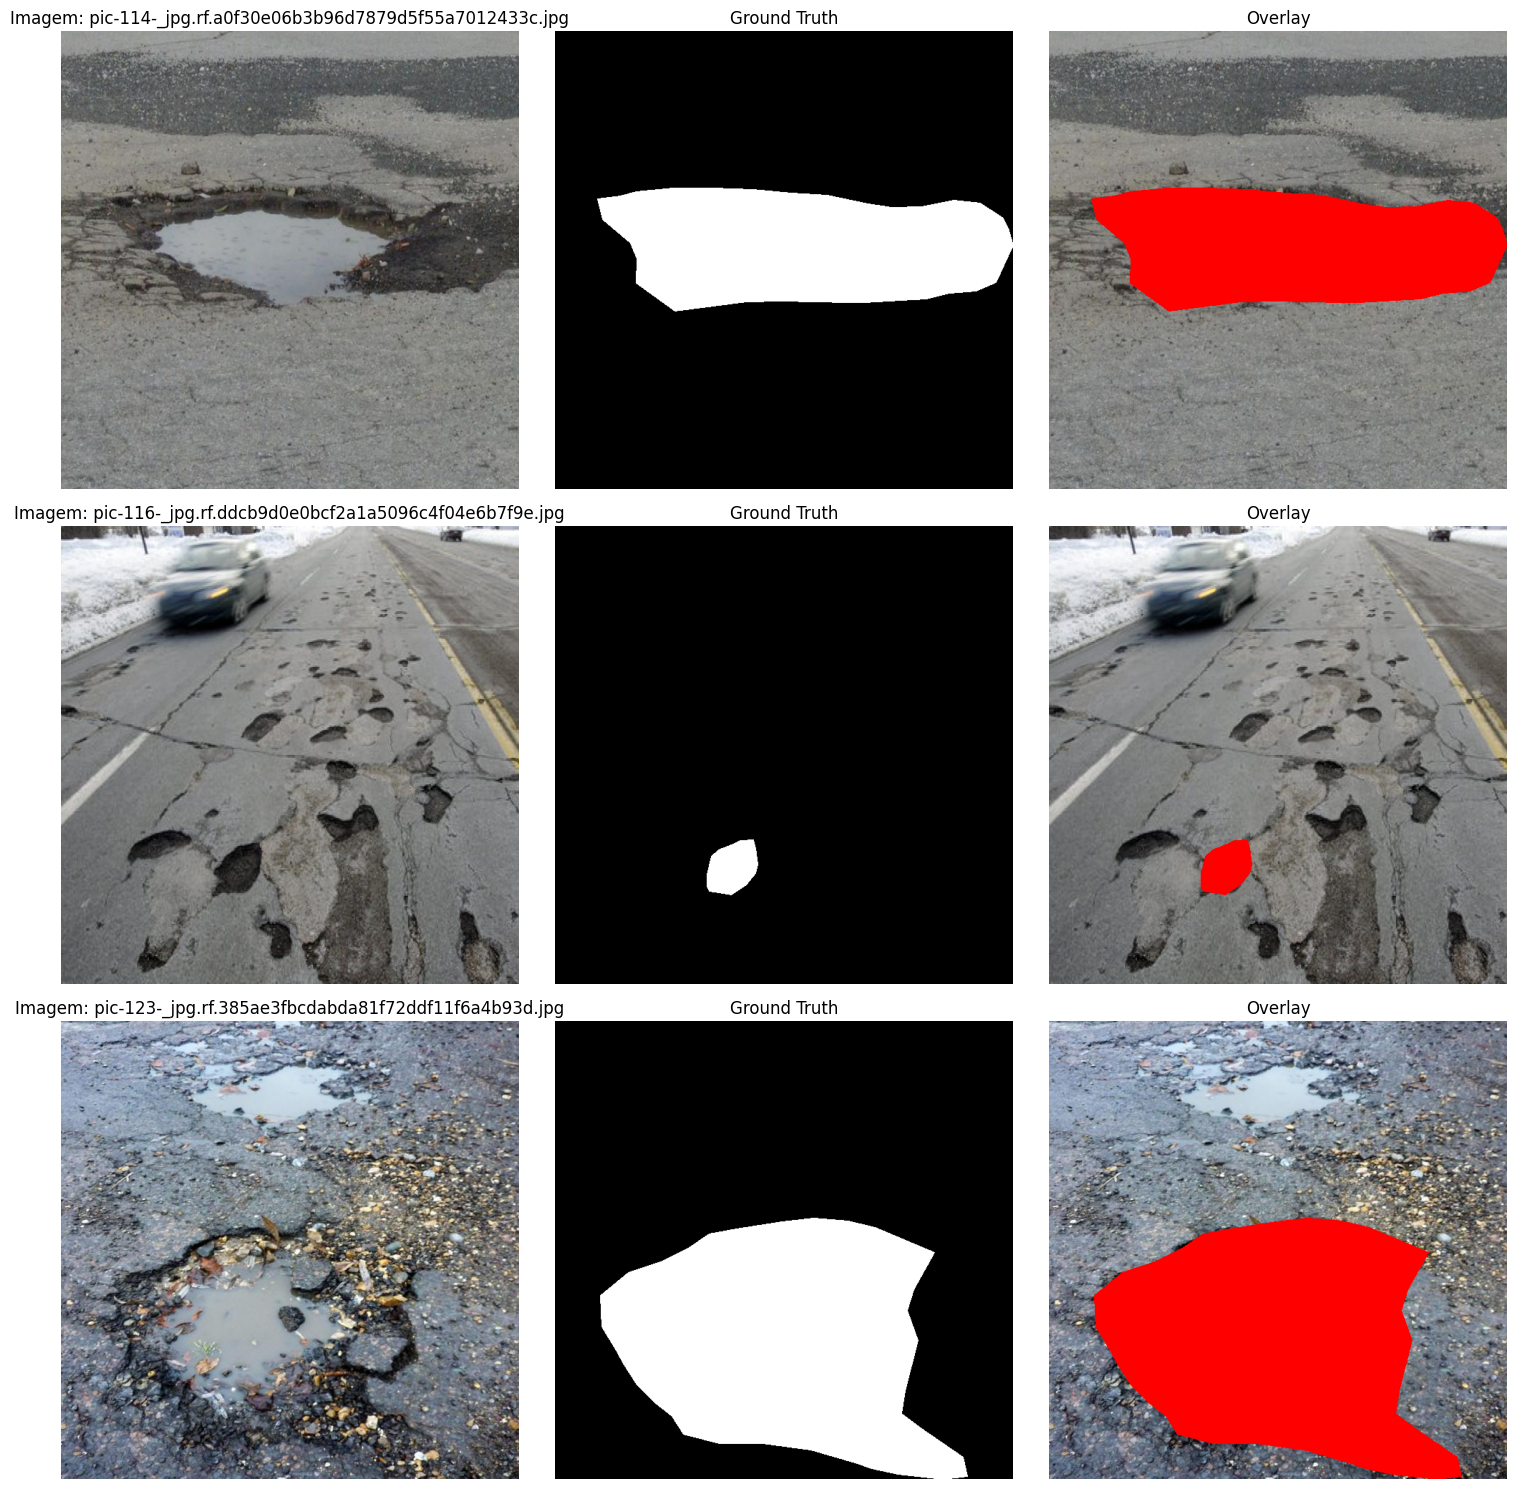

In [7]:
# Visualizar exemplos do dataset
def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        sample = dataset[i]
        image = sample['image']
        mask = sample['mask']

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Imagem: {sample['filename']}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        overlay = image.copy()
        overlay[mask == 1] = [255, 0, 0]
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(val_dataset, num_samples=3)

## 3. Download dos Modelos SAM

In [8]:
import urllib.request
import shutil # Importar shutil para copiar arquivos

# URLs dos checkpoints
checkpoint_urls = {
    "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
    "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
    "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
}

os.makedirs("checkpoints", exist_ok=True)

for model_type, url in checkpoint_urls.items():
    checkpoint_filename = os.path.basename(url)
    local_checkpoint_path = f"checkpoints/{checkpoint_filename}"
    drive_checkpoint_path = f"/content/drive/My Drive/Colab Models/checkpoints/{checkpoint_filename}"

    if not os.path.exists(local_checkpoint_path):
        if os.path.exists(drive_checkpoint_path):
            print(f"🔄 Copiando {model_type.upper()} do Google Drive para o ambiente local...")
            shutil.copy(drive_checkpoint_path, local_checkpoint_path)
            print(f"✅ {model_type.upper()} copiado do Drive!")
        else:
            print(f"⬇️  Baixando {model_type.upper()}...")
            urllib.request.urlretrieve(url, local_checkpoint_path)
            print(f"✅ {model_type.upper()} baixado!")
    else:
        print(f"✅ {model_type.upper()} já existe localmente!")

print("\n🎉 Todos os checkpoints prontos!")

✅ VIT_B já existe localmente!
✅ VIT_L já existe localmente!
✅ VIT_H já existe localmente!

🎉 Todos os checkpoints prontos!


## 4. Comparação entre Modelos SAM (ViT-B vs ViT-L vs ViT-H)

Vamos comparar os três tamanhos de modelo SAM em termos de:
- **Qualidade da segmentação** (IoU e Dice)
- **Tempo de inferência**
- **Qualidade visual**

In [9]:
def evaluate_model_comparison(models_dict, dataset, num_samples=20):
    """
    Compara diferentes modelos SAM
    """
    results = {}

    for model_name, model in models_dict.items():
        print(f"\n🔍 Avaliando {model_name}...")
        predictor = SamPredictor(model)

        metrics_list = []
        times = []

        for i in tqdm(range(min(num_samples, len(dataset)))):
            sample = dataset[i]
            image = sample['image']
            gt_mask = sample['mask']

            predictor.set_image(image)

            bbox = get_bbox_from_mask(gt_mask)
            if bbox is None:
                continue

            start_time = time.time()
            masks, scores, logits = predictor.predict(
                box=bbox,
                multimask_output=False
            )
            elapsed = time.time() - start_time

            pred_mask = masks[0]
            metrics = calculate_metrics(pred_mask, gt_mask)

            metrics_list.append(metrics)
            times.append(elapsed)

        avg_metrics = {
            'iou': np.mean([m['iou'] for m in metrics_list]),
            'dice': np.mean([m['dice'] for m in metrics_list]),
            'time': np.mean(times)
        }

        results[model_name] = avg_metrics
        print(f"  IoU: {avg_metrics['iou']:.4f} | Dice: {avg_metrics['dice']:.4f} | Tempo: {avg_metrics['time']:.4f}s")

    return results

In [10]:
# Carregar os três modelos
print("🔄 Carregando modelos SAM...")

sam_vit_b = sam_model_registry["vit_b"](checkpoint="checkpoints/sam_vit_b_01ec64.pth").to(device)
sam_vit_b.eval()

sam_vit_l = sam_model_registry["vit_l"](checkpoint="checkpoints/sam_vit_l_0b3195.pth").to(device)
sam_vit_l.eval()

sam_vit_h = sam_model_registry["vit_h"](checkpoint="checkpoints/sam_vit_h_4b8939.pth").to(device)
sam_vit_h.eval()

models_dict = {
    "ViT-B (Base)": sam_vit_b,
    "ViT-L (Large)": sam_vit_l,
    "ViT-H (Huge)": sam_vit_h
}

print("✅ Modelos carregados!")

🔄 Carregando modelos SAM...
✅ Modelos carregados!


In [11]:
# Comparar os modelos
model_comparison_results = evaluate_model_comparison(models_dict, val_dataset, num_samples=10)


🔍 Avaliando ViT-B (Base)...


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


  IoU: 0.6831 | Dice: 0.8032 | Tempo: 0.0665s

🔍 Avaliando ViT-L (Large)...


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


  IoU: 0.7489 | Dice: 0.8520 | Tempo: 0.0690s

🔍 Avaliando ViT-H (Huge)...


100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

  IoU: 0.7214 | Dice: 0.8270 | Tempo: 0.0947s



📊 COMPARAÇÃO ENTRE MODELOS SAM
                  iou    dice    time
ViT-B (Base)   0.6831  0.8032  0.0665
ViT-L (Large)  0.7489  0.8520  0.0690
ViT-H (Huge)   0.7214  0.8270  0.0947


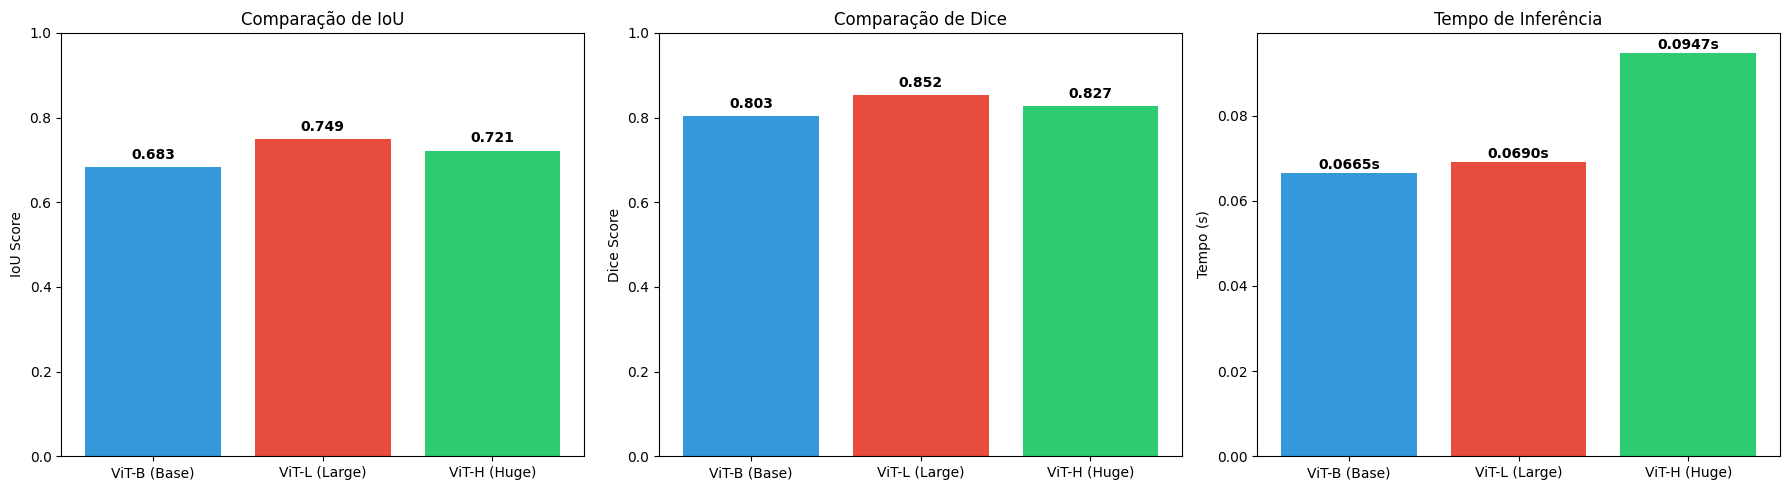

In [12]:
# Visualizar comparação
comparison_df = pd.DataFrame(model_comparison_results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*60)
print("📊 COMPARAÇÃO ENTRE MODELOS SAM")
print("="*60)
print(comparison_df)
print("="*60)

# Gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = list(model_comparison_results.keys())
iou_scores = [model_comparison_results[m]['iou'] for m in models]
dice_scores = [model_comparison_results[m]['dice'] for m in models]
times = [model_comparison_results[m]['time'] for m in models]

# IoU
axes[0].bar(models, iou_scores, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_ylabel('IoU Score')
axes[0].set_title('Comparação de IoU')
axes[0].set_ylim([0, 1])
for i, v in enumerate(iou_scores):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Dice
axes[1].bar(models, dice_scores, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Comparação de Dice')
axes[1].set_ylim([0, 1])
for i, v in enumerate(dice_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Tempo
axes[2].bar(models, times, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Tempo (s)')
axes[2].set_title('Tempo de Inferência')
for i, v in enumerate(times):
    axes[2].text(i, v + 0.001, f'{v:.4f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Avaliação SAM Pré-treinado com Diferentes Prompts

Vamos usar o **ViT-H** (melhor qualidade) e testar com:
- BBOX prompt
- Point prompt
- Automatic segmentation

In [13]:
# Usar ViT-H para o resto dos experimentos
sam_pretrained = sam_vit_h
print("✅ Usando SAM ViT-H para experimentos")

✅ Usando SAM ViT-H para experimentos


In [14]:
def evaluate_sam_with_prompt(model, dataset, prompt_type="bbox", num_samples=None):
    """
    Avalia SAM com diferentes tipos de prompts
    prompt_type: 'bbox', 'point', ou 'automatic'
    """
    if prompt_type == "automatic":
        mask_generator = SamAutomaticMaskGenerator(model)
    else:
        predictor = SamPredictor(model)

    metrics_list = []
    results = []

    n_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))

    print(f"🔍 Avaliando {n_samples} amostras com prompt={prompt_type}...")

    for i in tqdm(range(n_samples)):
        sample = dataset[i]
        image = sample['image']
        gt_mask = sample['mask']

        if prompt_type == "automatic":
            # Segmentação automática
            all_masks = mask_generator.generate(image)

            # Encontrar a máscara com maior IoU
            best_iou = 0
            best_mask = np.zeros_like(gt_mask)

            for mask_data in all_masks:
                mask = mask_data['segmentation'].astype(np.uint8)
                iou = calculate_iou(mask, gt_mask)
                if iou > best_iou:
                    best_iou = iou
                    best_mask = mask

            pred_mask = best_mask

        else:
            predictor.set_image(image)

            if prompt_type == "bbox":
                bbox = get_bbox_from_mask(gt_mask)
                if bbox is None:
                    continue

                masks, scores, logits = predictor.predict(
                    box=bbox,
                    multimask_output=False
                )
            else:  # point
                point = get_center_point_from_mask(gt_mask)
                if point is None:
                    continue

                point_labels = np.array([1])

                masks, scores, logits = predictor.predict(
                    point_coords=point,
                    point_labels=point_labels,
                    multimask_output=False
                )

            pred_mask = masks[0]

        metrics = calculate_metrics(pred_mask, gt_mask)
        metrics_list.append(metrics)

        results.append({
            'image': image,
            'gt_mask': gt_mask,
            'pred_mask': pred_mask,
            'metrics': metrics,
            'filename': sample['filename']
        })

    avg_metrics = {
        'iou': np.mean([m['iou'] for m in metrics_list]),
        'dice': np.mean([m['dice'] for m in metrics_list])
    }

    return avg_metrics, results

In [15]:
# Avaliar com BBOX
print("\n📦 === Avaliação com BBOX Prompt ===")
metrics_bbox, results_bbox = evaluate_sam_with_prompt(
    sam_pretrained, val_dataset, prompt_type="bbox", num_samples=50
)
print(f"  IoU: {metrics_bbox['iou']:.4f} | Dice: {metrics_bbox['dice']:.4f}")

# Avaliar com Point
print("\n📍 === Avaliação com Point Prompt ===")
metrics_point, results_point = evaluate_sam_with_prompt(
    sam_pretrained, val_dataset, prompt_type="point", num_samples=50
)
print(f"  IoU: {metrics_point['iou']:.4f} | Dice: {metrics_point['dice']:.4f}")

# Avaliar com Automatic (mais lento)
print("\n🤖 === Avaliação com Automatic Segmentation ===")
metrics_auto, results_auto = evaluate_sam_with_prompt(
    sam_pretrained, val_dataset, prompt_type="automatic", num_samples=20
)
print(f"  IoU: {metrics_auto['iou']:.4f} | Dice: {metrics_auto['dice']:.4f}")


📦 === Avaliação com BBOX Prompt ===
🔍 Avaliando 50 amostras com prompt=bbox...


100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


  IoU: 0.7133 | Dice: 0.8238

📍 === Avaliação com Point Prompt ===
🔍 Avaliando 50 amostras com prompt=point...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


  IoU: 0.4661 | Dice: 0.5803

🤖 === Avaliação com Automatic Segmentation ===
🔍 Avaliando 20 amostras com prompt=automatic...


100%|██████████| 20/20 [02:18<00:00,  6.94s/it]

  IoU: 0.4878 | Dice: 0.5853


## 6. Segmentação Iterativa com Refinamento Progressivo

Demonstra como adicionar pontos positivos e negativos progressivamente para refinar a segmentação.

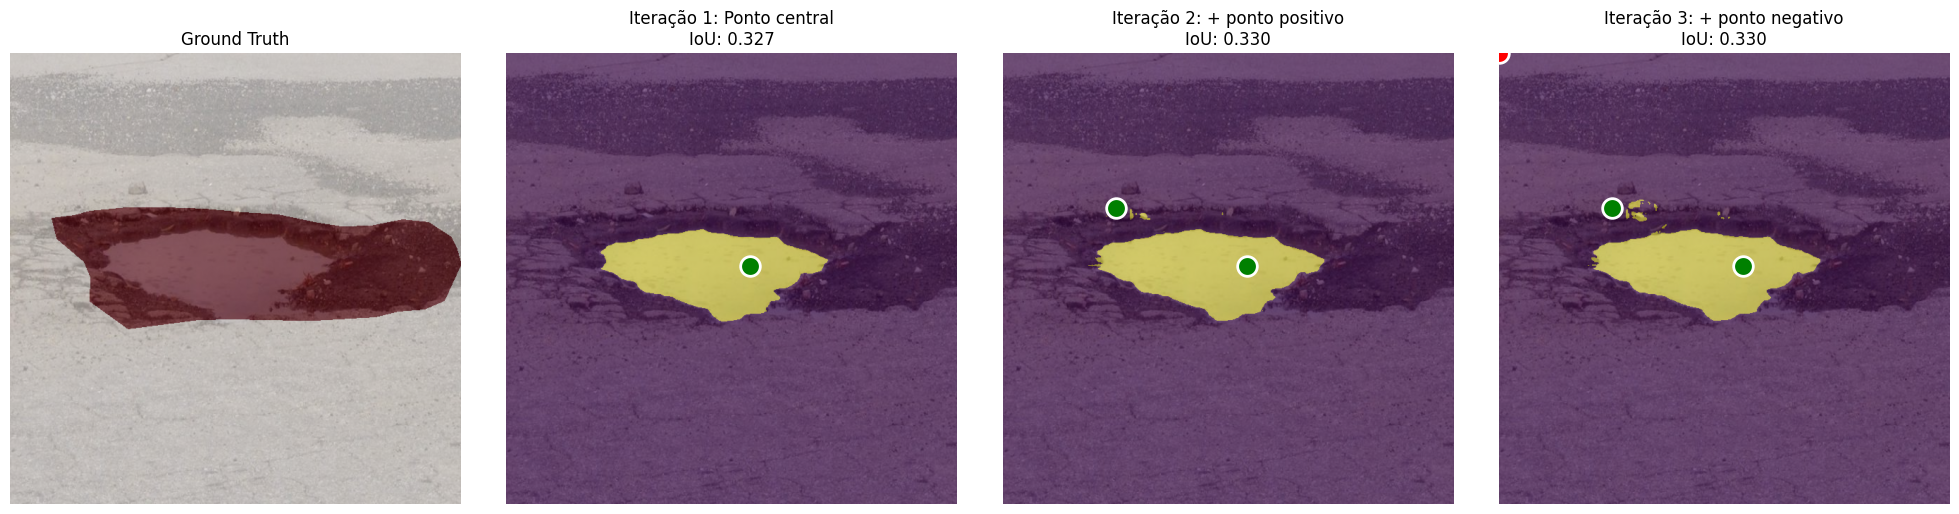

In [16]:
def demonstrate_iterative_segmentation(model, image, gt_mask):
    """
    Demonstra segmentação iterativa
    """
    predictor = SamPredictor(model)
    predictor.set_image(image)

    # Pegar pontos da máscara ground truth
    rows, cols = np.where(gt_mask > 0)
    if len(rows) == 0:
        return

    # Iterações
    iterations = [
        {"points": [[int(np.mean(cols)), int(np.mean(rows))]], "labels": [1], "title": "Iteração 1: Ponto central"},
        {"points": [[int(np.mean(cols)), int(np.mean(rows))], [cols[0], rows[0]]], "labels": [1, 1], "title": "Iteração 2: + ponto positivo"},
        {"points": [[int(np.mean(cols)), int(np.mean(rows))], [cols[0], rows[0]], [0, 0]], "labels": [1, 1, 0], "title": "Iteração 3: + ponto negativo"},
    ]

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Imagem original
    axes[0].imshow(image)
    axes[0].imshow(gt_mask, alpha=0.5, cmap='Reds')
    axes[0].set_title("Ground Truth")
    axes[0].axis('off')

    for idx, iteration in enumerate(iterations):
        points = np.array(iteration["points"])
        labels = np.array(iteration["labels"])

        masks, scores, _ = predictor.predict(
            point_coords=points,
            point_labels=labels,
            multimask_output=False
        )

        axes[idx+1].imshow(image)
        axes[idx+1].imshow(masks[0], alpha=0.5)

        # Plotar pontos
        for (x, y), label in zip(points, labels):
            color = 'green' if label == 1 else 'red'
            axes[idx+1].scatter(x, y, color=color, s=200, edgecolors='white', linewidth=2)

        iou = calculate_iou(masks[0], gt_mask)
        axes[idx+1].set_title(f"{iteration['title']}\nIoU: {iou:.3f}")
        axes[idx+1].axis('off')

    plt.tight_layout()
    plt.show()

# Demonstrar com uma imagem
sample = val_dataset[0]
demonstrate_iterative_segmentation(sam_pretrained, sample['image'], sample['mask'])

## 7. Fine-tuning do SAM

Agora vamos realizar o fine-tuning completo do SAM para a tarefa específica de segmentação de buracos.

In [17]:
# Preparar modelo para fine-tuning
sam_finetuned = sam_model_registry["vit_h"](checkpoint="checkpoints/sam_vit_h_4b8939.pth").to(device)
sam_finetuned.train()

# Congelar image encoder
for param in sam_finetuned.image_encoder.parameters():
    param.requires_grad = False

# Treinar mask decoder e prompt encoder
for param in sam_finetuned.mask_decoder.parameters():
    param.requires_grad = True

for param in sam_finetuned.prompt_encoder.parameters():
    param.requires_grad = True

optimizer = Adam(sam_finetuned.mask_decoder.parameters(), lr=1e-5)
loss_fn = BCEWithLogitsLoss()

trainable_params = sum(p.numel() for p in sam_finetuned.parameters() if p.requires_grad)
print(f"✅ Modelo preparado para fine-tuning!")
print(f"📊 Parâmetros treináveis: {trainable_params:,}")

✅ Modelo preparado para fine-tuning!
📊 Parâmetros treináveis: 4,064,560


In [18]:
def train_sam_optimized(model, train_dataset, val_dataset, num_epochs=10, batch_size=4, accumulation_steps=4):
    """
    Treina o modelo SAM com otimizações de GPU

    Otimizações:
    - Batch processing
    - Gradient accumulation
    - Mixed precision (AMP)
    - Pin memory
    - Non-blocking transfers
    """
    from torch.cuda.amp import autocast, GradScaler

    transform = ResizeLongestSide(model.image_encoder.img_size)
    scaler = GradScaler()  # Para mixed precision

    train_losses = []
    val_metrics = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        print(f"\n📈 Época {epoch+1}/{num_epochs}")

        indices = np.random.permutation(len(train_dataset))
        batch_images = []
        batch_masks = []
        batch_bboxes = []

        optimizer.zero_grad()

        pbar = tqdm(indices, desc="Treinando")
        for step, idx in enumerate(pbar):
            sample = train_dataset[idx]
            image = sample['image']
            gt_mask = sample['mask']

            if gt_mask.sum() == 0:
                continue

            bbox = get_bbox_from_mask(gt_mask)
            if bbox is None:
                continue

            # Acumular batch
            batch_images.append(image)
            batch_masks.append(gt_mask)
            batch_bboxes.append(bbox)

            # Processar quando atingir batch_size
            if len(batch_images) == batch_size or step == len(indices) - 1:
                if len(batch_images) == 0:
                    continue

                # Preparar batch tensors
                input_images_tensor = [] # Lista para os tensores de imagem após pré-processamento
                gt_masks_torch = []
                bboxes_torch = []
                original_sizes = []

                for img, mask, bbox in zip(batch_images, batch_masks, batch_bboxes):
                    # Aplicar a transformação e converter para float32 e normalizar para o treinamento
                    input_image = transform.apply_image(img)
                    input_images_tensor.append(
                        torch.as_tensor(input_image, device=device, dtype=torch.float32).permute(2, 0, 1) / 255.0
                    )
                    gt_masks_torch.append(
                        torch.as_tensor(mask, device=device, dtype=torch.float32)
                    )
                    bbox_transformed = transform.apply_boxes(bbox[None, :], img.shape[:2])
                    bboxes_torch.append(
                        torch.as_tensor(bbox_transformed, device=device, dtype=torch.float32)
                    )
                    original_sizes.append(img.shape[:2])

                # Stack em batch
                input_batch = torch.stack(input_images_tensor)

                # Mixed precision training
                with autocast():
                    # Image embeddings
                    with torch.no_grad():
                        image_embeddings = model.image_encoder(input_batch)

                    total_loss = 0

                    # Processar cada item do batch
                    for i in range(len(batch_images)):
                        sparse_embeddings, dense_embeddings = model.prompt_encoder(
                            points=None,
                            boxes=bboxes_torch[i],
                            masks=None,
                        )

                        low_res_masks, _ = model.mask_decoder(
                            image_embeddings=image_embeddings[i:i+1],
                            image_pe=model.prompt_encoder.get_dense_pe(),
                            sparse_prompt_embeddings=sparse_embeddings,
                            dense_prompt_embeddings=dense_embeddings,
                            multimask_output=False,
                        )

                        upscaled_masks = model.postprocess_masks(
                            low_res_masks,
                            input_size=(input_images_tensor[i].shape[1], input_images_tensor[i].shape[2]), # Use shape of transformed input
                            original_size=original_sizes[i]
                        )

                        gt_mask_torch = gt_masks_torch[i].unsqueeze(0).unsqueeze(0)
                        loss = loss_fn(upscaled_masks, gt_mask_torch) + dice_loss(upscaled_masks, gt_mask_torch)
                        total_loss += loss

                    # Média do batch
                    total_loss = total_loss / len(batch_images)
                    # Dividir por accumulation steps
                    total_loss = total_loss / accumulation_steps

                # Backward com gradient scaling
                scaler.scale(total_loss).backward()

                # Update a cada accumulation_steps
                if (step + 1) % accumulation_steps == 0 or step == len(indices) - 1:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                epoch_losses.append(total_loss.item() * accumulation_steps)
                pbar.set_postfix({'loss': f'{np.mean(epoch_losses):.4f}'})

                # Limpar batch
                batch_images = []
                batch_masks = []
                batch_bboxes = []

        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)

        print(f"  Loss médio: {avg_loss:.4f}")

        # Validação (mantém igual)
        model.eval()
        val_iou_list = []
        val_dice_list = []

        with torch.no_grad():
            for i in range(min(30, len(val_dataset))):
                sample = val_dataset[i]
                image = sample['image'] # numpy array, likely uint8
                gt_mask = sample['mask']

                if gt_mask.sum() == 0:
                    continue

                input_image = transform.apply_image(image) # still numpy array, likely uint8 after resize
                # Convert to float and normalize, then add batch dimension
                input_image_torch = torch.as_tensor(input_image, dtype=torch.float32, device=device) / 255.0
                input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

                image_embedding = model.image_encoder(input_image_torch)

                bbox = get_bbox_from_mask(gt_mask)
                if bbox is None:
                    continue

                bbox_transformed = transform.apply_boxes(bbox[None, :], image.shape[:2])
                bbox_torch = torch.as_tensor(bbox_transformed, dtype=torch.float, device=device)

                sparse_embeddings, dense_embeddings = model.prompt_encoder(
                    points=None,
                    boxes=bbox_torch,
                    masks=None,
                )

                low_res_masks, _ = model.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                )

                upscaled_masks = model.postprocess_masks(
                    low_res_masks,
                    input_size=(input_image.shape[0], input_image.shape[1]),
                    original_size=image.shape[:2]
                )

                pred_mask = (upscaled_masks[0, 0].cpu().numpy() > 0).astype(np.uint8)

                metrics = calculate_metrics(pred_mask, gt_mask)
                val_iou_list.append(metrics['iou'])
                val_dice_list.append(metrics['dice'])

        avg_val_iou = np.mean(val_iou_list) if val_iou_list else 0
        avg_val_dice = np.mean(val_dice_list) if val_dice_list else 0
        val_metrics.append({'iou': avg_val_iou, 'dice': avg_val_dice})

        print(f"  Validação - IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}")

    return train_losses, val_metrics

# Substituir a chamada por:
train_losses, val_metrics = train_sam_optimized(
    sam_finetuned,
    train_dataset,
    val_dataset,
    num_epochs=2,           # Reduzido para 2 épocas para demonstração mais rápida
    batch_size=2,           # Processa 2 imagens por vez
    accumulation_steps=2     # Batch efetivo = 4
)


📈 Época 1/2


Treinando: 100%|██████████| 720/720 [08:00<00:00,  1.50it/s, loss=0.2320]


  Loss médio: 0.2320
  Validação - IoU: 0.8327, Dice: 0.9058

📈 Época 2/2


Treinando: 100%|██████████| 720/720 [07:58<00:00,  1.50it/s, loss=0.1799]


  Loss médio: 0.1799
  Validação - IoU: 0.8363, Dice: 0.9079


Você já possui a pasta `checkpoints` criada. Agora, copie o modelo `sam_finetuned_complete.pth` para o seu Google Drive. Certifique-se de que o caminho para o seu Drive (`/content/drive/My Drive/`) está correto e que você tem uma pasta para salvar, ou pode criar uma se desejar.

In [19]:
# Crie uma pasta no seu Drive se ainda não tiver uma para seus modelos
!mkdir -p "/content/drive/My Drive/Colab Models"

# Copie a pasta de checkpoints inteira para o seu Google Drive
!cp -r "./checkpoints" "/content/drive/My Drive/Colab Models/"

# Verifique se os arquivos foram copiados com sucesso
!ls -lh "/content/drive/My Drive/Colab Models/checkpoints/"

^C
total 3.0G
-rw------- 1 root root 358M Nov 23 19:42 sam_vit_b_01ec64.pth
-rw------- 1 root root 1.5G Nov 23 20:13 sam_vit_h_4b8939.pth
-rw------- 1 root root 1.2G Nov 23 19:42 sam_vit_l_0b3195.pth


Se você tiver outros arquivos ou pastas que deseja salvar, basta adaptar o comando `cp`. Por exemplo, para salvar uma pasta inteira, use a flag `-r` (recursivo): `!cp -r "./my_folder" "/content/drive/My Drive/my_saved_folder/"`.

In [29]:
import torch
import gc

print(f"Memória da GPU antes da limpeza: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

# Opcional: Deletar variáveis grandes que não são mais necessárias
# Por exemplo, se você tem um modelo ou um tensor grande chamado 'my_model' ou 'large_tensor'
# del my_model
# del large_tensor

# Chamar o coletor de lixo do Python
gc.collect()

# Liberar a memória cache da GPU
torch.cuda.empty_cache()

print(f"Memória da GPU depois da limpeza: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

Memória da GPU antes da limpeza: 7213.98 MB
Memória da GPU depois da limpeza: 7213.98 MB


É importante notar que `torch.cuda.empty_cache()` só libera a memória que o PyTorch *reservou*, mas não está *em uso ativo*. Se você ainda estiver com problemas de OOM, pode ser necessário reduzir o tamanho do lote (`batch_size`) ou a complexidade do modelo.

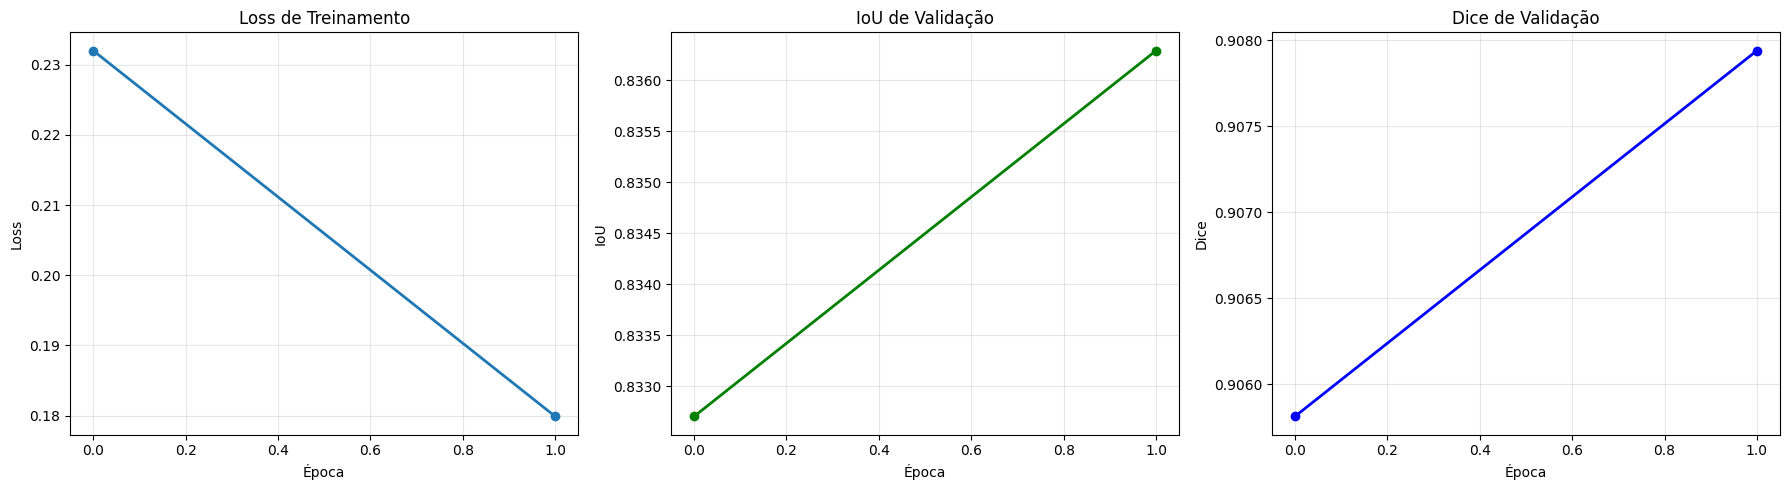

In [31]:
# Plotar curvas de treinamento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(train_losses, marker='o', linewidth=2)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss de Treinamento')
axes[0].grid(True, alpha=0.3)

iou_vals = [m['iou'] for m in val_metrics]
axes[1].plot(iou_vals, marker='o', color='green', linewidth=2)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('IoU')
axes[1].set_title('IoU de Validação')
axes[1].grid(True, alpha=0.3)

dice_vals = [m['dice'] for m in val_metrics]
axes[2].plot(dice_vals, marker='o', color='blue', linewidth=2)
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Dice')
axes[2].set_title('Dice de Validação')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Salvar modelo
torch.save(sam_finetuned.state_dict(), 'sam_finetuned_complete.pth')
print("💾 Modelo salvo como 'sam_finetuned_complete.pth'")

💾 Modelo salvo como 'sam_finetuned_complete.pth'


## 8. Avaliação do Modelo Fine-tuned

Vamos avaliar o modelo fine-tuned com BBOX e Point prompts.

In [23]:
# Avaliar fine-tuned com BBOX
print("\n📦 === Avaliação SAM Fine-tuned com BBOX Prompt ===")
sam_finetuned.eval()
metrics_finetuned_bbox, results_finetuned_bbox = evaluate_sam_with_prompt(
    sam_finetuned, val_dataset, prompt_type="bbox", num_samples=50
)
print(f"  IoU: {metrics_finetuned_bbox['iou']:.4f} | Dice: {metrics_finetuned_bbox['dice']:.4f}")

# Avaliar fine-tuned com Point
print("\n📍 === Avaliação SAM Fine-tuned com Point Prompt ===")
metrics_finetuned_point, results_finetuned_point = evaluate_sam_with_prompt(
    sam_finetuned, val_dataset, prompt_type="point", num_samples=50
)
print(f"  IoU: {metrics_finetuned_point['iou']:.4f} | Dice: {metrics_finetuned_point['dice']:.4f}")


📦 === Avaliação SAM Fine-tuned com BBOX Prompt ===
🔍 Avaliando 50 amostras com prompt=bbox...


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


  IoU: 0.8406 | Dice: 0.9111

📍 === Avaliação SAM Fine-tuned com Point Prompt ===
🔍 Avaliando 50 amostras com prompt=point...


100%|██████████| 50/50 [01:45<00:00,  2.12s/it]

  IoU: 0.5115 | Dice: 0.6245


## 9. Comparação Final: Todos os Métodos

In [24]:
# Criar tabela de comparação completa
final_comparison = pd.DataFrame({
    'Método': [
        'SAM Pré-treinado (BBOX)',
        'SAM Pré-treinado (Point)',
        'SAM Pré-treinado (Automatic)',
        'SAM Fine-tuned (BBOX)',
        'SAM Fine-tuned (Point)'
    ],
    'IoU': [
        metrics_bbox['iou'],
        metrics_point['iou'],
        metrics_auto['iou'],
        metrics_finetuned_bbox['iou'],
        metrics_finetuned_point['iou']
    ],
    'Dice': [
        metrics_bbox['dice'],
        metrics_point['dice'],
        metrics_auto['dice'],
        metrics_finetuned_bbox['dice'],
        metrics_finetuned_point['dice']
    ]
})

print("\n" + "="*70)
print("📊 COMPARAÇÃO FINAL - TODOS OS MÉTODOS")
print("="*70)
print(final_comparison.to_string(index=False))
print("="*70)

# Calcular melhorias
improvement_bbox_iou = ((metrics_finetuned_bbox['iou'] - metrics_bbox['iou']) / metrics_bbox['iou']) * 100
improvement_bbox_dice = ((metrics_finetuned_bbox['dice'] - metrics_bbox['dice']) / metrics_bbox['dice']) * 100

improvement_point_iou = ((metrics_finetuned_point['iou'] - metrics_point['iou']) / metrics_point['iou']) * 100
improvement_point_dice = ((metrics_finetuned_point['dice'] - metrics_point['dice']) / metrics_point['dice']) * 100

print(f"\n🚀 Melhoria com fine-tuning (BBOX):")
print(f"  IoU: {improvement_bbox_iou:+.2f}%")
print(f"  Dice: {improvement_bbox_dice:+.2f}%")

print(f"\n🚀 Melhoria com fine-tuning (Point):")
print(f"  IoU: {improvement_point_iou:+.2f}%")
print(f"  Dice: {improvement_point_dice:+.2f}%")


📊 COMPARAÇÃO FINAL - TODOS OS MÉTODOS
                      Método      IoU     Dice
     SAM Pré-treinado (BBOX) 0.713300 0.823754
    SAM Pré-treinado (Point) 0.466118 0.580300
SAM Pré-treinado (Automatic) 0.487765 0.585343
       SAM Fine-tuned (BBOX) 0.840586 0.911109
      SAM Fine-tuned (Point) 0.511492 0.624507

🚀 Melhoria com fine-tuning (BBOX):
  IoU: +17.84%
  Dice: +10.60%

🚀 Melhoria com fine-tuning (Point):
  IoU: +9.73%
  Dice: +7.62%


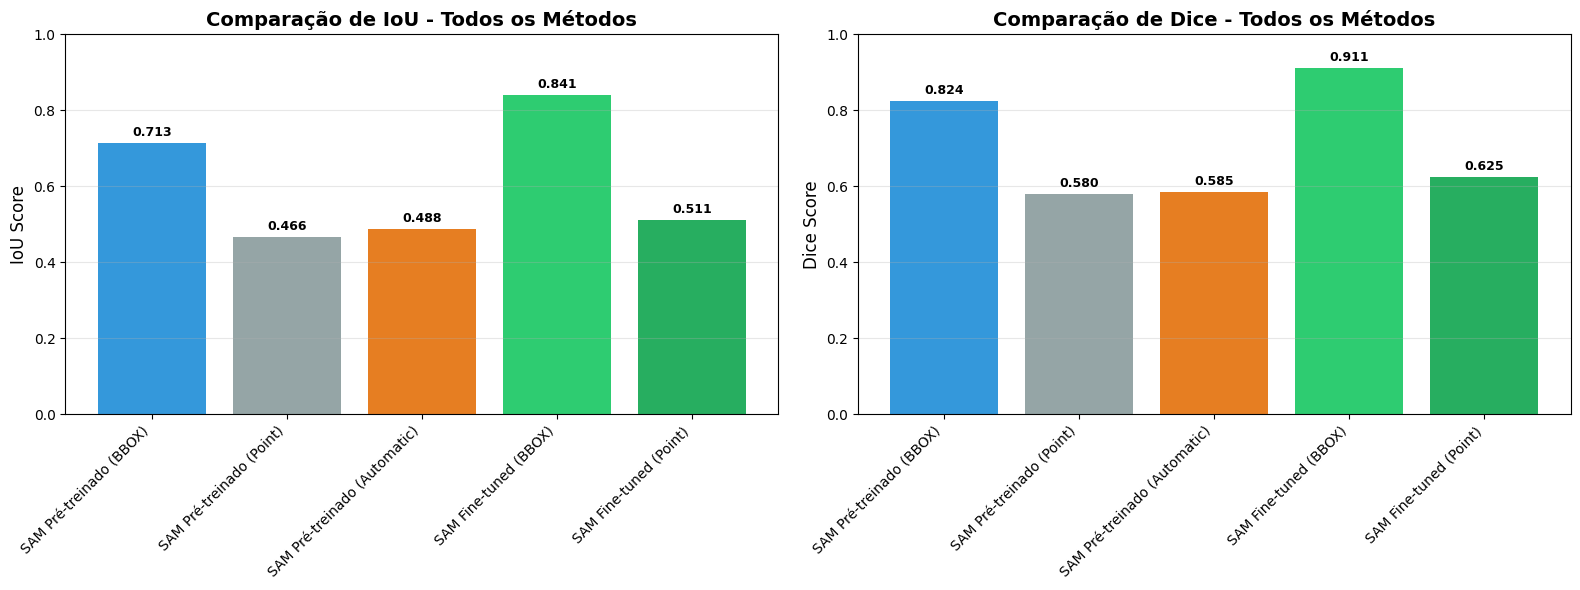

In [25]:
# Gráfico final comparativo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

methods = final_comparison['Método'].tolist()
iou_scores = final_comparison['IoU'].tolist()
dice_scores = final_comparison['Dice'].tolist()

colors = ['#3498db', '#95a5a6', '#e67e22', '#2ecc71', '#27ae60']

# IoU
bars1 = axes[0].bar(range(len(methods)), iou_scores, color=colors)
axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods, rotation=45, ha='right')
axes[0].set_ylabel('IoU Score', fontsize=12)
axes[0].set_title('Comparação de IoU - Todos os Métodos', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Dice
bars2 = axes[1].bar(range(len(methods)), dice_scores, color=colors)
axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods, rotation=45, ha='right')
axes[1].set_ylabel('Dice Score', fontsize=12)
axes[1].set_title('Comparação de Dice - Todos os Métodos', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## 10. Grounded-SAM: Segmentação com Text Prompts

Implementação do Grounded-SAM usando **Grounding DINO** para detectar objetos a partir de texto + **SAM** para segmentação precisa.

**Fluxo**: Texto "pothole" → Grounding DINO → Bounding Boxes → SAM → Máscaras

In [26]:
# Download Grounding DINO
try:
    from groundingdino.util.inference import Model as GroundingDINO
    import supervision as sv

    grounding_dino_config_url = "https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py"
    grounding_dino_checkpoint_url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"

    config_path = "GroundingDINO_SwinT_OGC.py"
    checkpoint_path_gdino = "groundingdino_swint_ogc.pth"

    if not os.path.exists(config_path):
        print("⬇️  Baixando config do Grounding DINO...")
        urllib.request.urlretrieve(grounding_dino_config_url, config_path)

    if not os.path.exists(checkpoint_path_gdino):
        print("⬇️  Baixando checkpoint do Grounding DINO...")
        urllib.request.urlretrieve(grounding_dino_checkpoint_url, checkpoint_path_gdino)

    print("✅ Grounding DINO pronto!")

    # Carregar Grounding DINO
    grounding_dino_model = GroundingDINO(
        model_config_path=config_path,
        model_checkpoint_path=checkpoint_path_gdino
    )

    GROUNDED_SAM_AVAILABLE = True
    print("✅ Grounding DINO carregado!")

except Exception as e:
    print(f"⚠️  Grounded-SAM não disponível: {e}")
    print("Pulando esta seção...")
    GROUNDED_SAM_AVAILABLE = False

⬇️  Baixando config do Grounding DINO...
⬇️  Baixando checkpoint do Grounding DINO...
✅ Grounding DINO pronto!
final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ Grounding DINO carregado!


In [27]:
if GROUNDED_SAM_AVAILABLE:
    def evaluate_grounded_sam(text_prompt, sam_model, gdino_model, dataset, num_samples=20):
        """
        Avalia Grounded-SAM com text prompts
        """
        sam_predictor = SamPredictor(sam_model)

        metrics_list = []
        results = []

        print(f"🔍 Avaliando Grounded-SAM com texto: '{text_prompt}'")

        for i in tqdm(range(min(num_samples, len(dataset)))):
            sample = dataset[i]
            image = sample['image']
            gt_mask = sample['mask']

            # Grounding DINO detecta objetos
            detections = gdino_model.predict_with_classes(
                image=image,
                classes=[text_prompt],
                box_threshold=0.25,
                text_threshold=0.25
            )

            if len(detections.xyxy) == 0:
                # Não detectou nada, usar máscara vazia
                pred_mask = np.zeros_like(gt_mask)
            else:
                # SAM segmenta usando as boxes
                sam_predictor.set_image(image)

                # Pegar a box com maior confiança
                best_box = detections.xyxy[0]

                masks, scores, _ = sam_predictor.predict(
                    box=best_box,
                    multimask_output=False
                )

                pred_mask = masks[0]

            metrics = calculate_metrics(pred_mask, gt_mask)
            metrics_list.append(metrics)

            results.append({
                'image': image,
                'gt_mask': gt_mask,
                'pred_mask': pred_mask,
                'metrics': metrics,
                'filename': sample['filename']
            })

        avg_metrics = {
            'iou': np.mean([m['iou'] for m in metrics_list]),
            'dice': np.mean([m['dice'] for m in metrics_list])
        }

        return avg_metrics, results

    # Testar com diferentes prompts
    text_prompts = ["pothole", "hole", "road damage"]

    grounded_results = {}

    for prompt in text_prompts:
        print(f"\n🔤 === Testando prompt: '{prompt}' ===")
        metrics, results = evaluate_grounded_sam(
            prompt, sam_pretrained, grounding_dino_model, val_dataset, num_samples=20
        )
        grounded_results[prompt] = metrics
        print(f"  IoU: {metrics['iou']:.4f} | Dice: {metrics['dice']:.4f}")

    # Comparar resultados
    print("\n" + "="*60)
    print("📊 RESULTADOS GROUNDED-SAM")
    print("="*60)
    for prompt, metrics in grounded_results.items():
        print(f"'{prompt}': IoU={metrics['iou']:.4f}, Dice={metrics['dice']:.4f}")
    print("="*60)
else:
    print("⏭️  Pulando Grounded-SAM (não disponível)")


🔤 === Testando prompt: 'pothole' ===
🔍 Avaliando Grounded-SAM com texto: 'pothole'


100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


  IoU: 0.4907 | Dice: 0.5814

🔤 === Testando prompt: 'hole' ===
🔍 Avaliando Grounded-SAM com texto: 'hole'


100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


  IoU: 0.4230 | Dice: 0.5033

🔤 === Testando prompt: 'road damage' ===
🔍 Avaliando Grounded-SAM com texto: 'road damage'


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]

  IoU: 0.1419 | Dice: 0.2160

📊 RESULTADOS GROUNDED-SAM
'pothole': IoU=0.4907, Dice=0.5814
'hole': IoU=0.4230, Dice=0.5033
'road damage': IoU=0.1419, Dice=0.2160


## 11. Visualizações Comparativas Finais

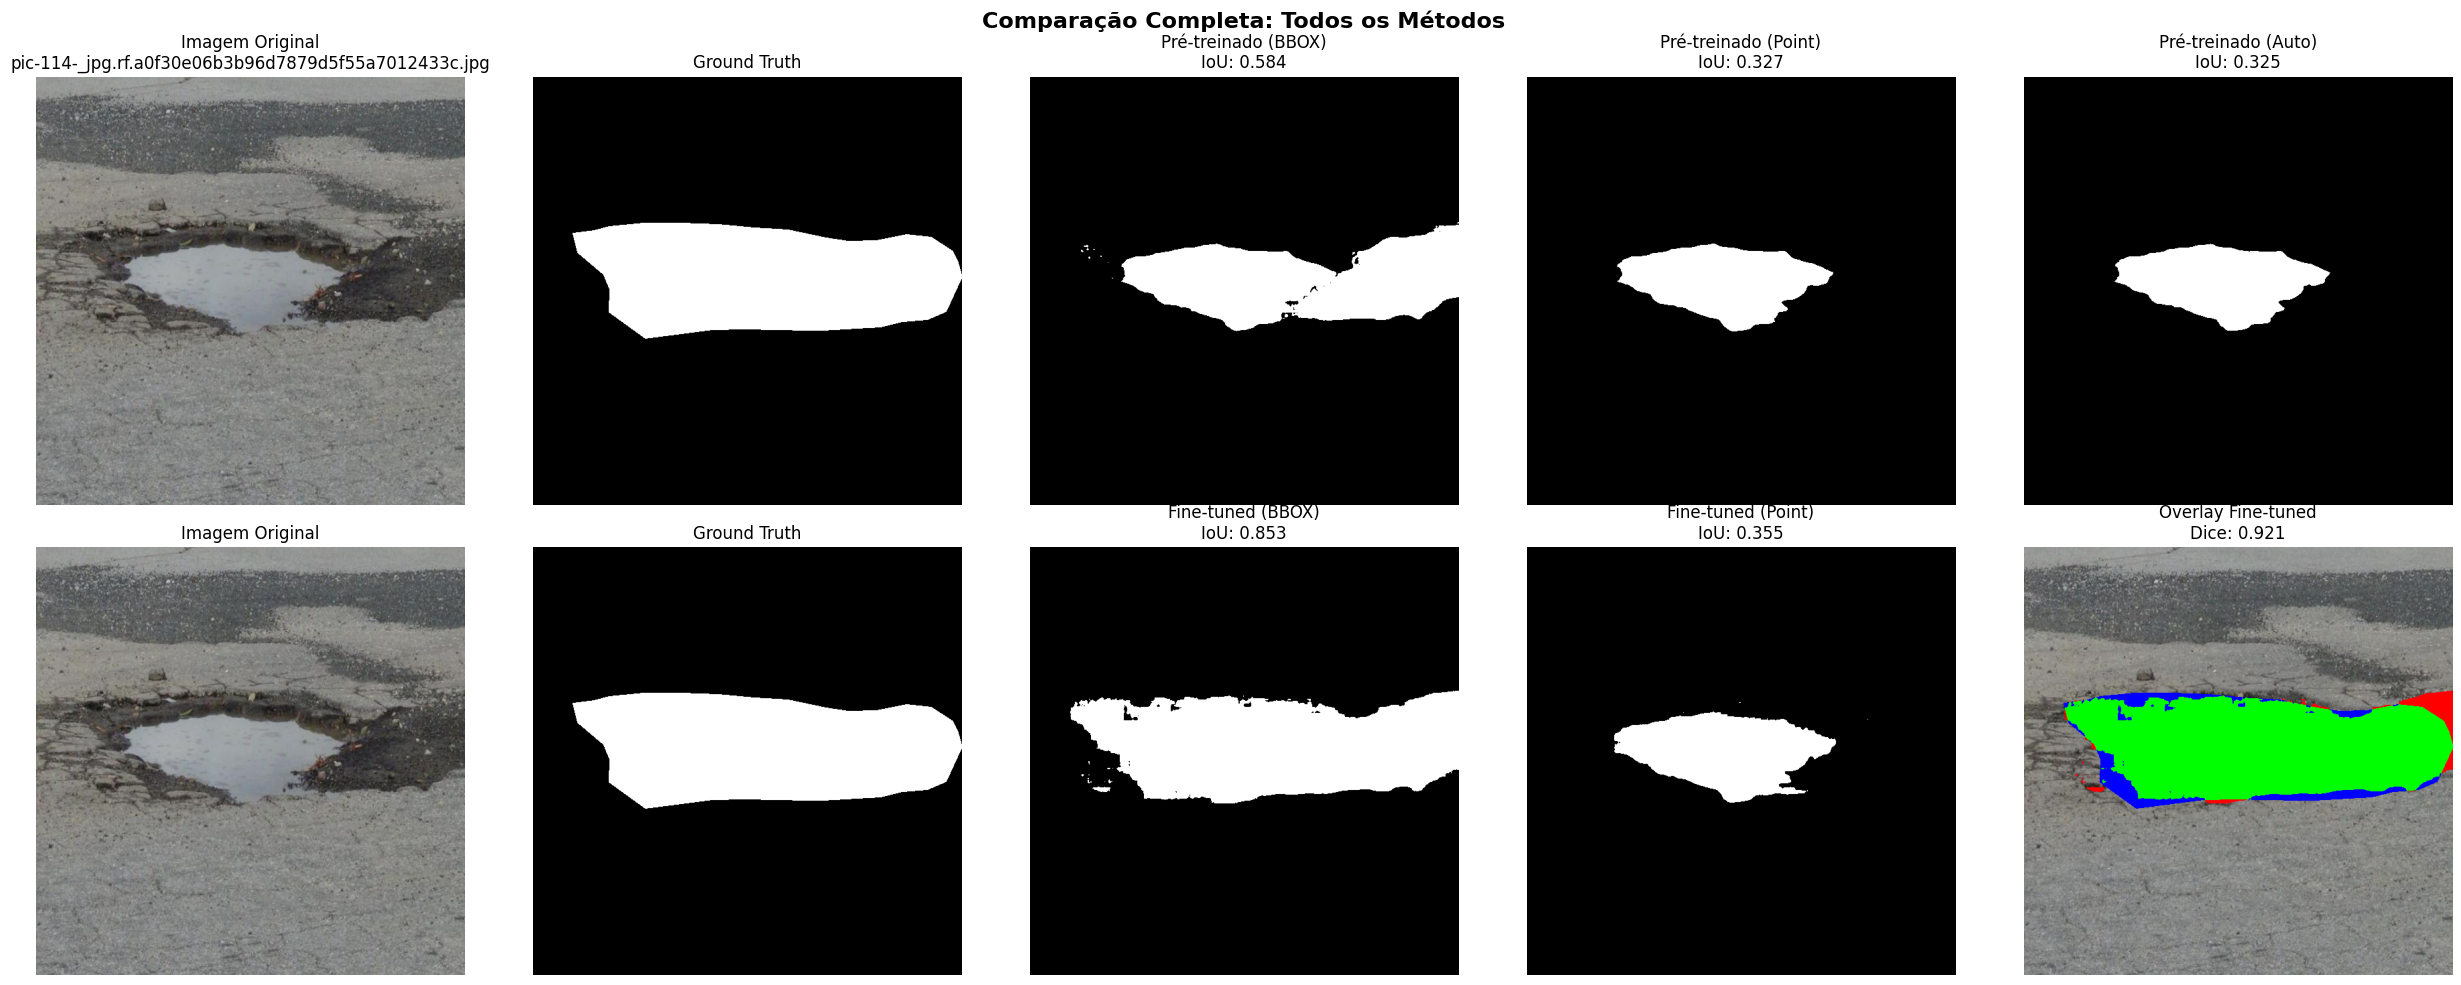

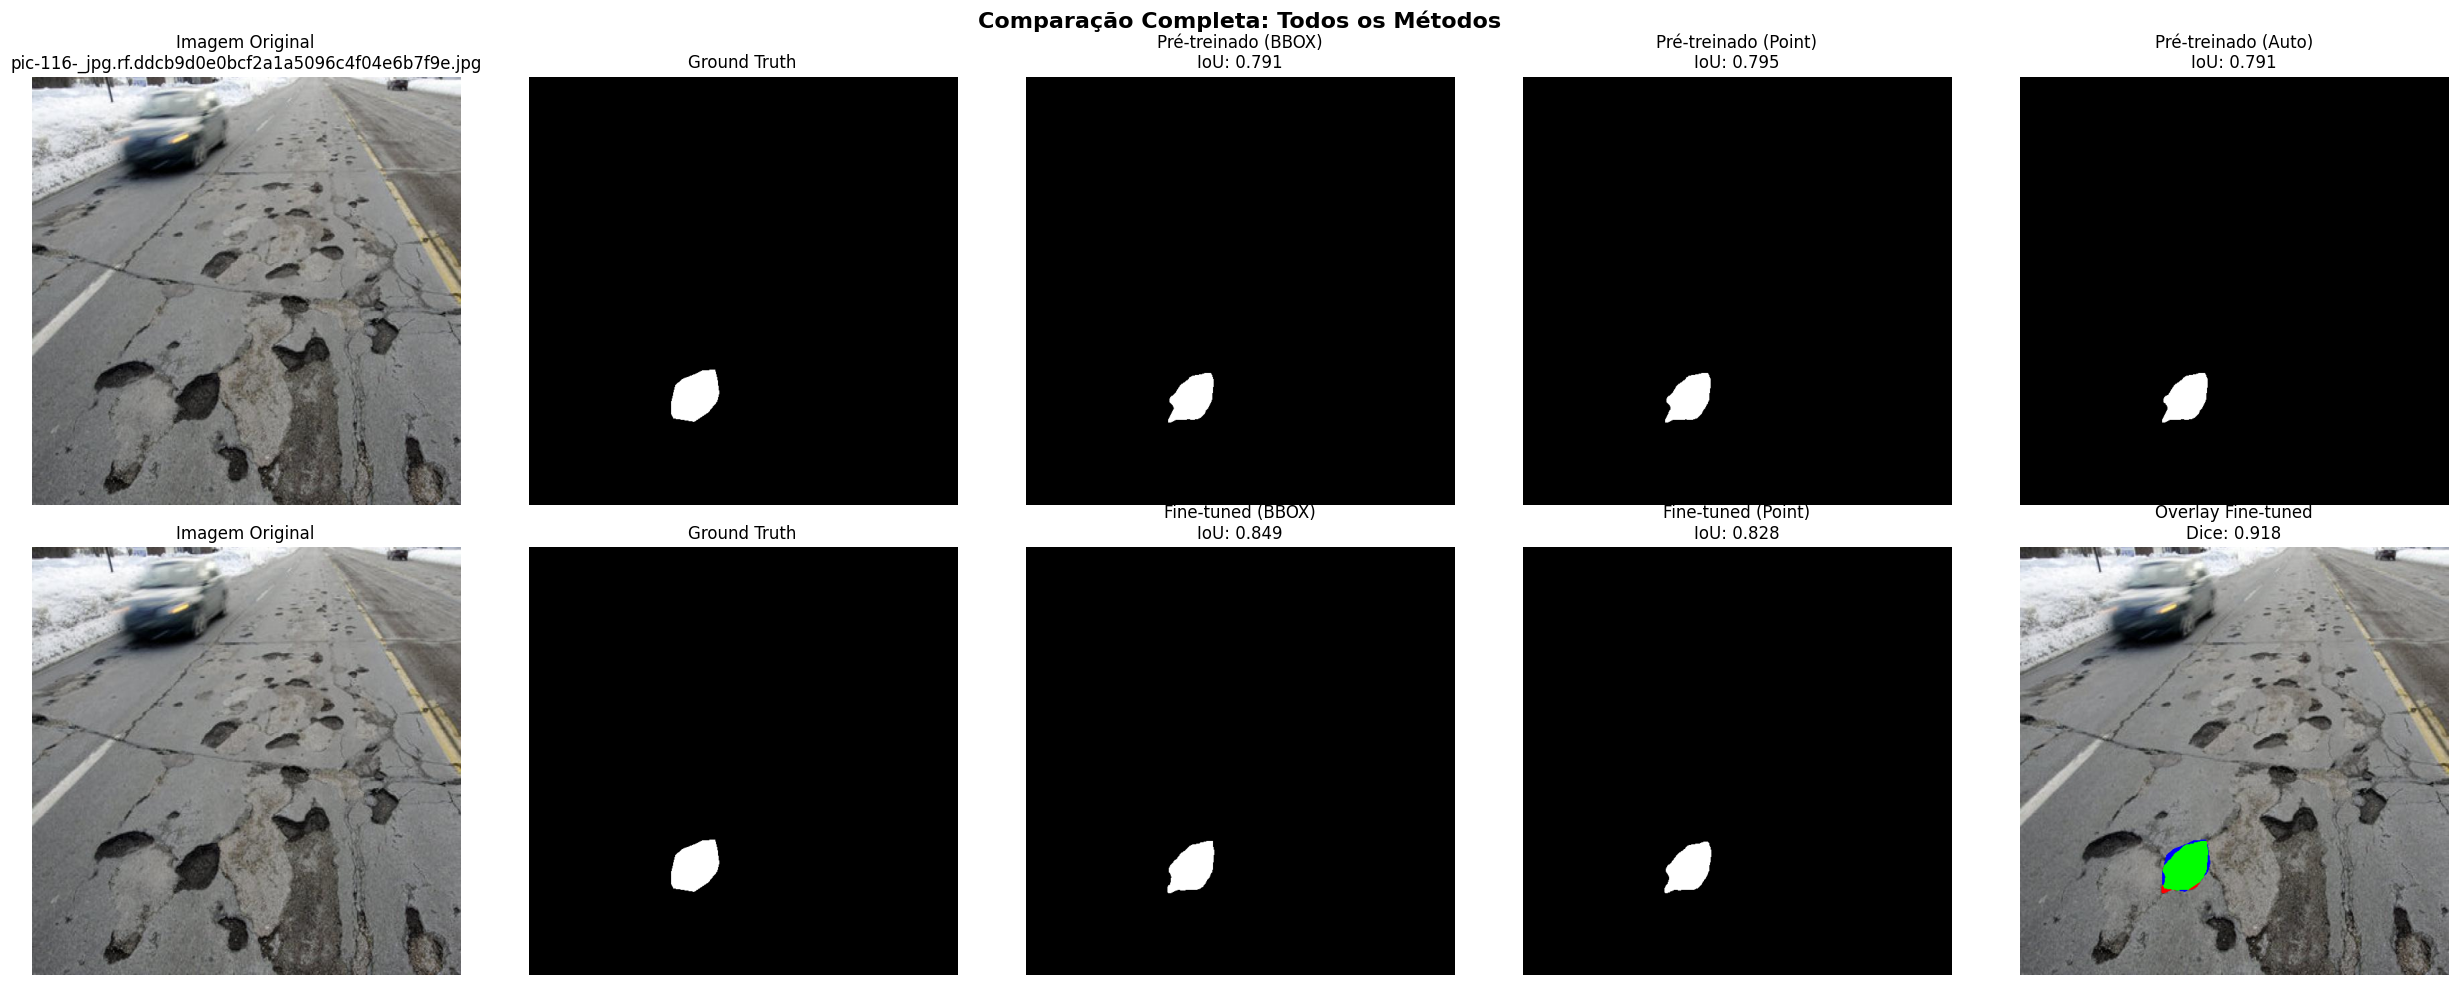

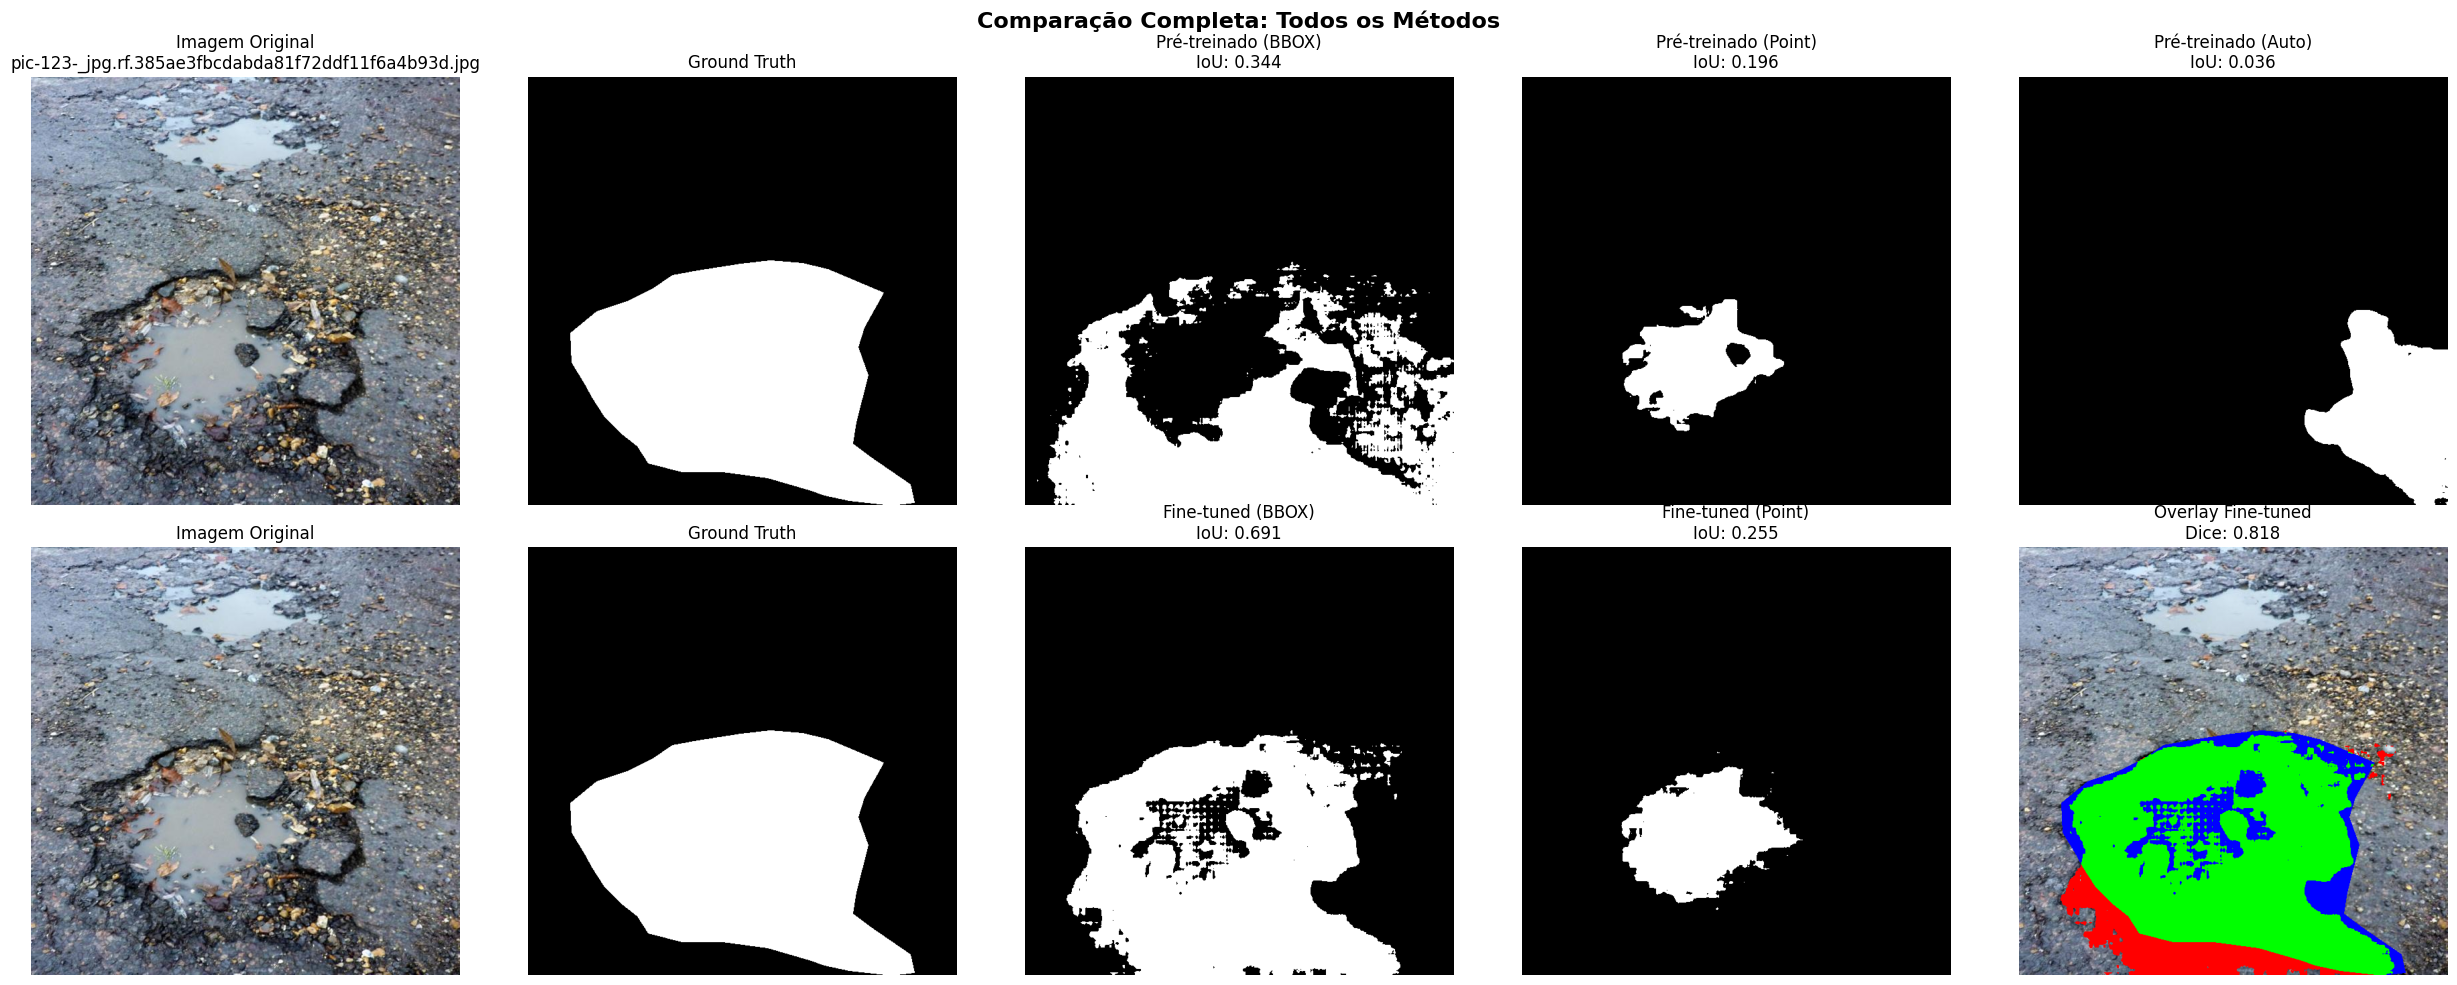

In [28]:
def visualize_all_methods(idx):
    """Visualiza todos os métodos lado a lado"""

    fig, axes = plt.subplots(2, 5, figsize=(25, 10))

    # Linha 1: Pré-treinado
    result_bbox = results_bbox[idx]
    result_point = results_point[idx]
    result_auto = results_auto[min(idx, len(results_auto)-1)]

    axes[0, 0].imshow(result_bbox['image'])
    axes[0, 0].set_title(f"Imagem Original\n{result_bbox['filename']}")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(result_bbox['gt_mask'], cmap='gray')
    axes[0, 1].set_title("Ground Truth")
    axes[0, 1].axis('off')

    axes[0, 2].imshow(result_bbox['pred_mask'], cmap='gray')
    axes[0, 2].set_title(f"Pré-treinado (BBOX)\nIoU: {result_bbox['metrics']['iou']:.3f}")
    axes[0, 2].axis('off')

    axes[0, 3].imshow(result_point['pred_mask'], cmap='gray')
    axes[0, 3].set_title(f"Pré-treinado (Point)\nIoU: {result_point['metrics']['iou']:.3f}")
    axes[0, 3].axis('off')

    axes[0, 4].imshow(result_auto['pred_mask'], cmap='gray')
    axes[0, 4].set_title(f"Pré-treinado (Auto)\nIoU: {result_auto['metrics']['iou']:.3f}")
    axes[0, 4].axis('off')

    # Linha 2: Fine-tuned
    result_ft_bbox = results_finetuned_bbox[idx]
    result_ft_point = results_finetuned_point[idx]

    axes[1, 0].imshow(result_ft_bbox['image'])
    axes[1, 0].set_title("Imagem Original")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(result_ft_bbox['gt_mask'], cmap='gray')
    axes[1, 1].set_title("Ground Truth")
    axes[1, 1].axis('off')

    axes[1, 2].imshow(result_ft_bbox['pred_mask'], cmap='gray')
    axes[1, 2].set_title(f"Fine-tuned (BBOX)\nIoU: {result_ft_bbox['metrics']['iou']:.3f}")
    axes[1, 2].axis('off')

    axes[1, 3].imshow(result_ft_point['pred_mask'], cmap='gray')
    axes[1, 3].set_title(f"Fine-tuned (Point)\nIoU: {result_ft_point['metrics']['iou']:.3f}")
    axes[1, 3].axis('off')

    # Comparação overlay
    overlay = result_ft_bbox['image'].copy()
    tp = np.logical_and(result_ft_bbox['pred_mask'], result_ft_bbox['gt_mask'])
    fp = np.logical_and(result_ft_bbox['pred_mask'], np.logical_not(result_ft_bbox['gt_mask']))
    fn = np.logical_and(np.logical_not(result_ft_bbox['pred_mask']), result_ft_bbox['gt_mask'])
    overlay[tp] = [0, 255, 0]
    overlay[fp] = [255, 0, 0]
    overlay[fn] = [0, 0, 255]

    axes[1, 4].imshow(overlay)
    axes[1, 4].set_title(f"Overlay Fine-tuned\nDice: {result_ft_bbox['metrics']['dice']:.3f}")
    axes[1, 4].axis('off')

    plt.suptitle("Comparação Completa: Todos os Métodos", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar 3 exemplos
for i in range(3):
    visualize_all_methods(i)